# Heart disease classification

In this notebook we will be exploring how to create a classificatory algorithm and how to tune our models to it in an efficient way. We will be using the Heart Attack Prediction dataset available on [Kaggle](https://www.kaggle.com/imnikhilanand/heart-attack-prediction).

**About this data set**
This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The target field refers to the presence of heart disease in the patient. It is integer valued 0 = no/less chance of heart attack and 1 = more chance of heart attack

**Attribute Information**
1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
14. target: 0= less chance of heart attack 1= more chance of heart attack

In [1]:
import sys 
print("Python version: {}". format(sys.version))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display 
print("IPython version: {}". format(IPython.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

import random
import time

import warnings
warnings.filterwarnings('ignore')
print('-'*25)

# Visualization defaults
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import PowerTransformer 
from numpy import loadtxt
from xgboost import XGBClassifier, plot_importance
from matplotlib import pyplot
import sklearn
import lightgbm 
from sklearn import svm
from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection
from sklearn.metrics import roc_curve, auc
from numpy import interp
from matplotlib import rcParams
from plotnine import *

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
pandas version: 1.0.3
matplotlib version: 3.2.1
NumPy version: 1.18.5
SciPy version: 1.4.1
IPython version: 7.13.0
scikit-learn version: 0.23.1
-------------------------
health-care-data-set-on-heart-attack-possibility



In [2]:
heart = pd.read_csv('../input/health-care-data-set-on-heart-attack-possibility/heart.csv')

# EDA

It is a good thing to start by taking a peek at the dataset.

In [3]:
heart.sample(n = 10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
191,58,1,0,128,216,0,0,131,1,2.2,1,3,3,0
65,35,0,0,138,183,0,1,182,0,1.4,2,0,2,1
171,48,1,1,110,229,0,1,168,0,1.0,0,0,3,0
128,52,0,2,136,196,0,0,169,0,0.1,1,0,2,1
88,54,0,2,110,214,0,1,158,0,1.6,1,0,2,1
156,47,1,2,130,253,0,1,179,0,0.0,2,0,2,1
41,48,1,1,130,245,0,0,180,0,0.2,1,0,2,1
103,42,1,2,120,240,1,1,194,0,0.8,0,0,3,1
80,41,1,2,112,250,0,1,179,0,0.0,2,0,2,1
13,64,1,3,110,211,0,0,144,1,1.8,1,0,2,1


In [4]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


First up, we need to check if there's any missing value on our dataset

In [5]:
print('Train columns with null values:\n', heart.isnull().sum())
print("-" * 10)

Train columns with null values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
----------


We don't need to do any preprocessing for missing values.

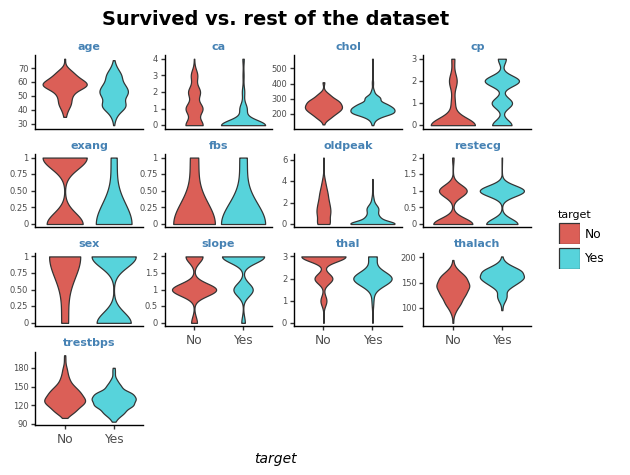

<ggplot: (8766828306321)>

In [6]:
rcParams['figure.figsize'] = 18, 10
train_plot = pd.melt(heart, id_vars = ['target'], value_vars = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'])
train_plot['target'] = train_plot['target'].astype('category')
train_plot['target'].replace(0, 'No', inplace = True)
train_plot['target'].replace(1, 'Yes', inplace = True)

ggplot(train_plot, aes(x = 'target', y = 'value', fill = 'target')) + \
    geom_violin() + \
    theme_classic() + \
    theme(axis_title_y = element_blank(),
          axis_title_x = element_text(size = 10, face = 'italic'),
          subplots_adjust = {'wspace':0.2},
          strip_background = element_blank(),
          strip_text = element_text(size = 8, colour = 'steelblue', face = 'bold'),
          axis_text_y = element_text(size = 6),
          legend_title = element_text(size = 8),
          plot_title = element_text(size = 14, face = 'bold')) + \
    labs(title = 'Survived vs. rest of the dataset') + \
    facet_wrap('~variable', scales = 'free_y')

Some features such as sex, age, chest pain or ST depression looks related to the risk of having a heart condition. It looks feasible to create a classificatory model to predict heart attack risk. First thing then would be to check whether there's a good balance in our dataset between people with heart condition or not. Otherwise we are gonna need to do some resampling technique.

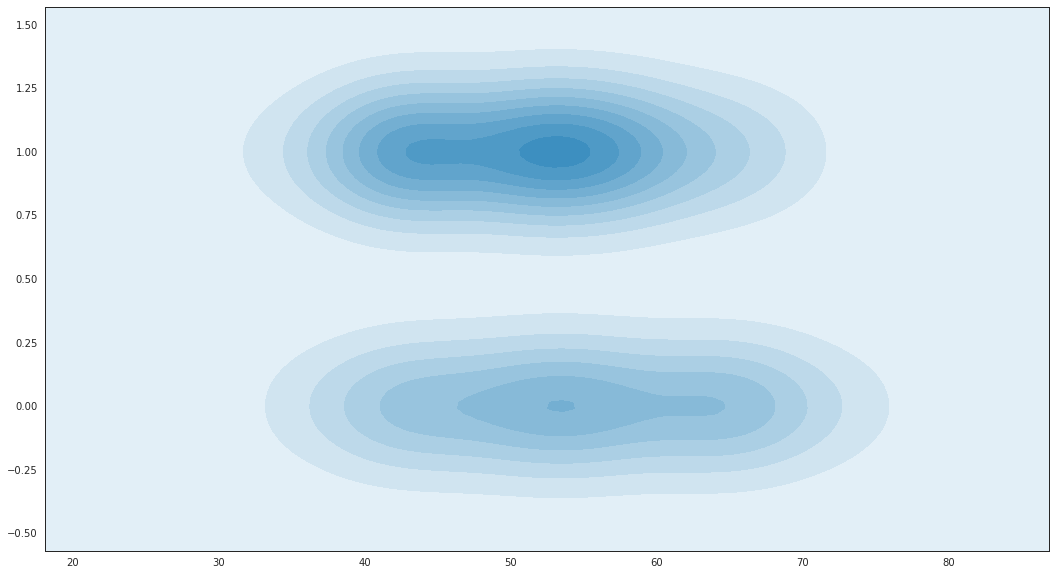

In [7]:
sns.kdeplot(heart[heart.target == 0], shade = True)
sns.kdeplot(heart[heart.target == 1], shade = True)

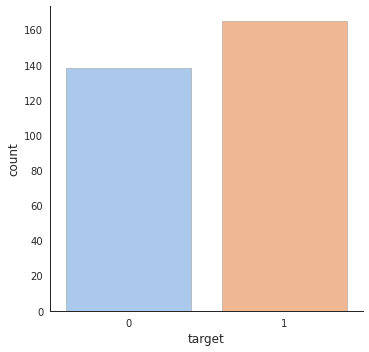

In [8]:
sns.catplot(x = 'target', data = heart, kind = 'count',
           palette="pastel", edgecolor=".6")

It's a balanced dataset. No need of resampling or balancing the target categories, so we can proceed with the dataset as it is.

The next step is to check whether there're outlier values. We're going to draw a boxplot with the only 4 numerical features on the model.

Text(0.5, 1.0, 'Numerical features boxplots')

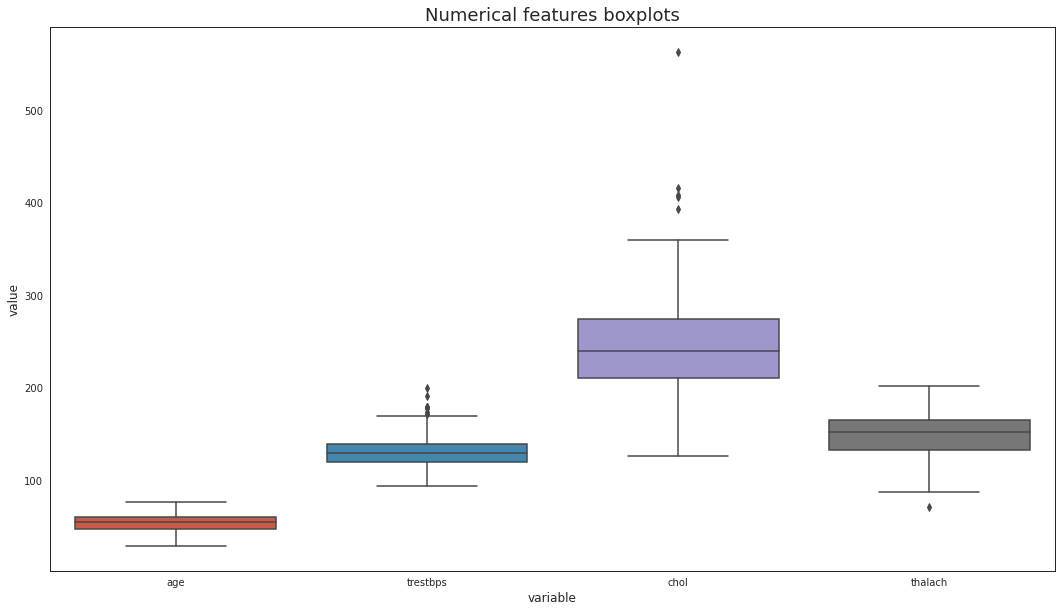

In [9]:
sns.boxplot(x = 'variable', y = 'value', data = pd.melt(heart[['age', 'trestbps', 'chol', 'thalach']])).set_title('Numerical features boxplots', size = 18)

There're a few outliers in the cholesterol variable, but they seem to be accurate and not due to any input error, so it's better not to remove them from the analysis in order to make it more conservative.

Now, we need to do something with the rest of features. They are categorical so we need to create dummy features for each one of them if we want to avoid creating any cardinality out of them.

In [10]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


These are the candidates to be converted into dummy features:
1. sex
2. cp (Chest pain)
3. fbs (fasting blood sugar) 
4. restecg (resting electrocardiagraphic results) 
5. exang (exercise induced angina)
6. slope (slope of the peak exercise) 
7. ca (colored vessels)
8. thal 

In [11]:
to_dummies = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
def dummify(model, to_dummies):
    
    if np.isnan(model.values).any() == True:
        print('Check out for missing values!')
        
    model = pd.get_dummies(model, columns = to_dummies)
    return model

heart = dummify(heart, to_dummies)

With this, we need to check the correlation between variables. Since this is a classificatory model, multicolinearility shouldn't be an issue, we just need to analyze if we can explain variance on the target variable with the available features.

Text(0.5, 1.0, 'Correlation Heatmap Matrix')

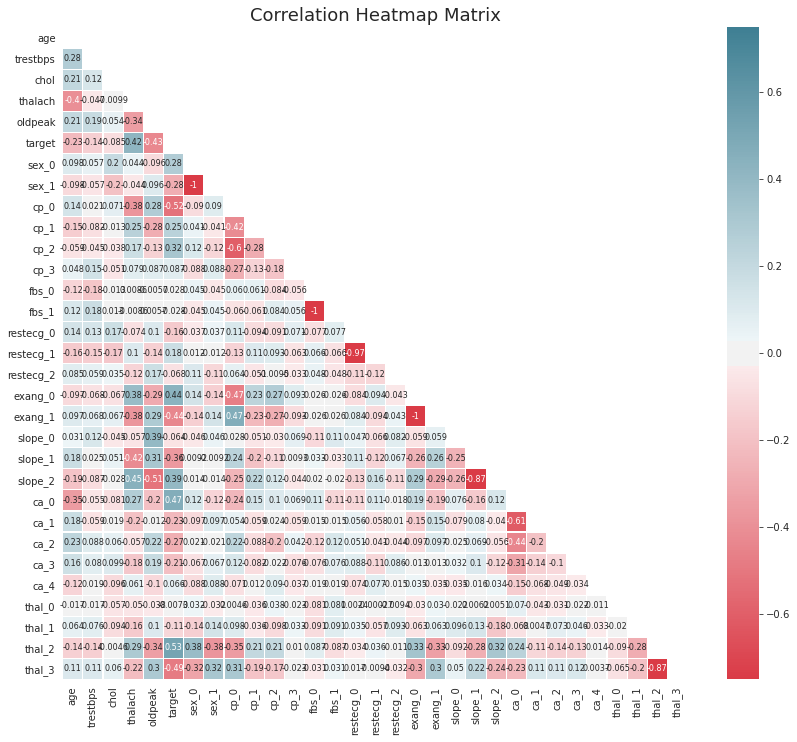

In [12]:
mask_ut = np.triu(np.ones(heart.corr().shape)).astype(np.bool)

def correlation_heatmap(df, center = None):
    fig, ax = plt.subplots(figsize = [14, 12])
    colormap = sns.diverging_palette(10, 220, as_cmap = True)
    fig = sns.heatmap(df.corr(),
                     cmap = colormap,
                     center = center,
                     annot = True,
                     mask = mask_ut,
                     linewidths = 0.1,
                     vmin = -0.75, vmax = 0.75, #show just significants
                     annot_kws = {'fontsize':8})
    
correlation_heatmap(heart, center = 0)
plt.title('Correlation Heatmap Matrix', size = 18)

As we suspected in the first place, some variables as thal, slope of peak exercise, sex and colesterol are strong correlated to the risk of having a heart condition.

# Feature Engineering

Next up, we need to standardize using the z-score formula to make the make the features of our new dataset more uniform.

In [13]:
heart.sample(n=10)

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
278,58,136,319,152,0.0,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0
163,38,138,175,173,0.0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
69,62,124,209,163,0.0,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0
134,41,126,306,163,0.0,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
180,55,132,353,132,1.2,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
66,51,100,222,143,1.2,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
195,59,170,326,140,3.4,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
61,54,108,309,156,0.0,1,0,1,0,1,...,1,1,0,0,0,0,0,0,0,1
147,60,150,240,171,0.9,1,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0
24,40,140,199,178,1.4,1,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1


In [14]:
from scipy import stats
target_col = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
heart[target_col] = stats.zscore(heart[target_col], axis=0, ddof=1)

In [15]:
heart.describe()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
count,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,1.392359e-17,-7.738584e-16,-9.151096e-17,-5.650046e-16,8.207589e-17,0.544554,0.316832,0.683168,0.471947,0.165017,...,0.468647,0.577558,0.214521,0.125413,0.066007,0.016502,0.006601,0.059406,0.547855,0.386139
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.498835,0.466011,0.466011,0.500038,0.371809,...,0.499842,0.494765,0.411169,0.331734,0.248704,0.127605,0.081110,0.236774,0.498528,0.487668
min,-2.793003e+00,-2.145254e+00,-2.320322e+00,-3.433587e+00,-8.953805e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.560295e-01,-6.627704e-01,-6.803688e-01,-7.049444e-01,-8.953805e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.977057e-02,-9.258463e-02,-1.208554e-01,1.463921e-01,-2.063639e-01,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,7.304107e-01,4.776012e-01,5.447726e-01,7.139498e-01,4.826527e-01,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,2.492118e+00,3.898716e+00,6.130260e+00,2.285648e+00,4.444498e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
X_var = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex_0', 'sex_1',
         'cp_0', 'cp_1', 'cp_2', 'cp_3', 'fbs_0', 'fbs_1', 'restecg_0',
         'restecg_1', 'restecg_2', 'exang_0', 'exang_1', 'slope_0', 'slope_1',
         'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1',
         'thal_2', 'thal_3']

X_train, X_test, y_train, y_test = train_test_split(heart[X_var],
                                   heart['target'],
                                   test_size = 0.2, random_state = 25)

print('The train subset has {0} rows. \nThe test subset has {1} rows.'.format(X_train.shape[0], X_test.shape[0]) )

The train subset has 242 rows. 
The test subset has 61 rows.


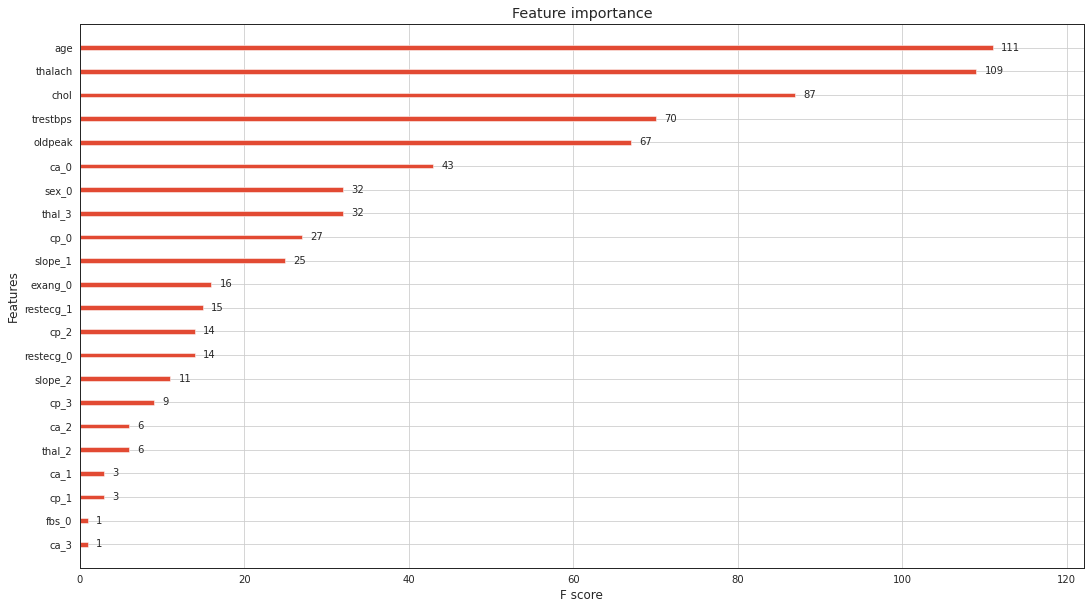

In [17]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

plot_importance(classifier)
pyplot.show()

# Model selection

AdaB: 0.794548 (0.110873)
Bagg: 0.783396 (0.085721)
ExtTreeS: 0.842629 (0.063389)
GradB: 0.788489 (0.089066)
RF: 0.855490 (0.073322)
GaussProc: 0.824868 (0.075315)
LR: 0.825810 (0.087461)
PassAg: 0.718569 (0.157456)
Ridge: 0.865004 (0.076155)
SGDC: 0.777955 (0.072629)
Perc: 0.741455 (0.130999)
BernNB: 0.853134 (0.063595)
GaussNB: 0.734250 (0.083075)
KNN: 0.832956 (0.056920)
SVM: 0.848408 (0.074815)
NuSVM: 0.837332 (0.065315)
LinearSVC: 0.848649 (0.087842)
CART: 0.762406 (0.085179)
ExtTree: 0.791273 (0.049823)
LDA: 0.867205 (0.053677)
QuadDA: 0.484696 (0.236651)
XGB: 0.786564 (0.087586)
LightGBM: 0.805556 (0.084611)


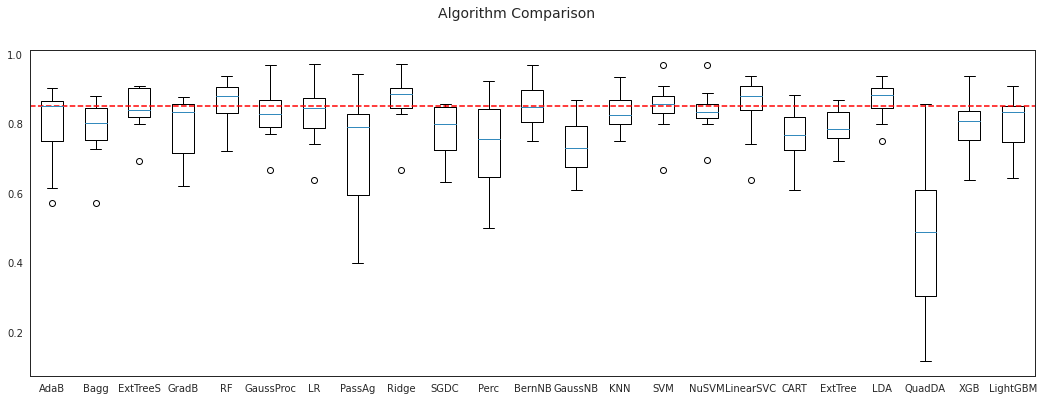

In [18]:
MLA = []
kfold = 8
scoring = 'f1' #accuracy
hline_thres = 0.85

    #Ensemble Methods
MLA.append(('AdaB', ensemble.AdaBoostClassifier()))  
MLA.append(('Bagg', ensemble.BaggingClassifier()))   
MLA.append(('ExtTreeS', ensemble.ExtraTreesClassifier()))    
MLA.append(('GradB', ensemble.GradientBoostingClassifier()))  
MLA.append(('RF', ensemble.RandomForestClassifier()))
    # Gaussian Process
MLA.append(('GaussProc', gaussian_process.GaussianProcessClassifier()))
    #GLM
MLA.append(('LR', linear_model.LogisticRegressionCV()))
MLA.append(('PassAg', linear_model.PassiveAggressiveClassifier()))
MLA.append(('Ridge', linear_model.RidgeClassifierCV()))
MLA.append(('SGDC', linear_model.SGDClassifier()))
MLA.append(('Perc', linear_model.Perceptron()))

    # Naive Bayes
MLA.append(('BernNB', naive_bayes.BernoulliNB()))
MLA.append(('GaussNB', naive_bayes.GaussianNB()))
    # KNN
MLA.append(('KNN', neighbors.KNeighborsClassifier()))
    #SVM
MLA.append(('SVM', svm.SVC(probability = True)))
MLA.append(('NuSVM', svm.NuSVC(probability = True)))
MLA.append(('LinearSVC', svm.LinearSVC()))
    # Trees
MLA.append(('CART', tree.DecisionTreeClassifier()))
MLA.append(('ExtTree', tree.ExtraTreeClassifier()))
    #Discriminant Analysis
MLA.append(('LDA', discriminant_analysis.LinearDiscriminantAnalysis()))
MLA.append(('QuadDA', discriminant_analysis.QuadraticDiscriminantAnalysis()))
    # Boost
MLA.append(('XGB', XGBClassifier()))
    # Bagging
MLA.append(('LightGBM', lightgbm.LGBMClassifier()))
    
results = []
names = []

for name, model in MLA:
    kfold = model_selection.KFold(n_splits = 10, random_state = 1)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure(figsize = (18, 6))
fig.suptitle('Algorithm Comparison', size = 14)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.axhline(y = hline_thres, color = 'r', linestyle = 'dashed')
plt.show()

According to our research, the best candidates are:
1. ExtraTrees
2. Random Forest
3. Logistic Regression
4. Ridge
5. SVM
6. NuSVM
7. LinearSVC
8. LDA

Additionaly, we may want to try again with a tuned XGBoost and LightGBM. The mix of a boosting and a bagging model can add an extra efficiency to our ensemble model.

# Tunning parameters

In light of the example, we are going to explain step by step how to tune a Random Forest model from a brute force approach. First things first, we will try using the model as it is, without tuning any parameters.

In [19]:
xgb = XGBClassifier(random_state = 1)

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = {},
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  # To convert to normalized gini, multiply the obtained AUC values by 2 and subtract 1.
print('\n Best hyperparameters:')
print(grid_search.best_params_)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best normalized gini score for 5-fold search:
0.7386574822236587

 Best hyperparameters:
{}


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    3.0s finished


Normalized Gini for a raw model is 0.739, which is not that good... Let's proceed with a grid search with CV.
First step: select the best number of estimators and depth of the forest.

As a scoring formula, we will be using the normalized Gini, which can be obtained multiplying AUC values by 2 and then subtract 1.

In [20]:
xgb = XGBClassifier(random_state = 1)

params = {'max_depth': range(3, 10, 1),
          'min_child_weight': range(1, 6, 1)
         }

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 35 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best normalized gini score for 5-fold search:
0.7678672430510667

 Best hyperparameters:
{'max_depth': 3, 'min_child_weight': 5}


[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:    5.2s finished


Gini score improved from 0.73 to 0.76. Perhaps we can further improve this score. Now let's turn our attention to the Gamma parameter.

In [21]:
xgb = XGBClassifier(random_state = 1)

params = {'max_depth': [3],
          'min_child_weight': [5],
          'gamma' :[i/10.0 for i in range(0,8)]
         }

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 8 candidates, totalling 64 fits

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best normalized gini score for 5-fold search:
0.7689328135100193

 Best hyperparameters:
{'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 5}


[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    1.1s finished


It doesn't improve that much. The problem we see here is that there might be too many features with too low variance. We can try subsampling the dataset to reduce the noise of those features.

In [22]:
xgb = XGBClassifier(random_state = 1)

params = {'max_depth': [3],
          'min_child_weight': [5],
          'gamma' : [0.1],
          'colsample_bytree': np.arange(0.6, 1, 0.1),
          'subsample': np.arange(0.6, 1, 0.1)
         }

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 16 candidates, totalling 128 fits

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best normalized gini score for 5-fold search:
0.8227415966386553

 Best hyperparameters:
{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7}


[Parallel(n_jobs=4)]: Done 128 out of 128 | elapsed:    1.9s finished


Subsampling helps us not only improve accuracy but also shorten the model running time. Now we just need to try with some regularization.

In [23]:
xgb = XGBClassifier(random_state = 1)

params = {'max_depth': [3],
          'min_child_weight': [5],
          'gamma' : [0.1],
          'colsample_bytree': [0.6],
          'subsample': [0.7],
          'reg_alpha': np.arange(0, 1, 0.05),
          'reg_lambda': np.arange(0, 2, 0.05)
         }

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 800 candidates, totalling 6400 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 1728 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 3128 tasks      | elapsed:   41.0s
[Parallel(n_jobs=4)]: Done 4928 tasks      | elapsed:  1.1min



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0.9500000000000001, reg_lambda=1.0, scale_pos_weight=1,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best normalized gini score for 5-fold search:
0.8329528926955398

 Best hyperparameters:
{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'reg_alpha': 0.9500000000000001, 'reg_lambda': 1.0, 'subsample': 0.7}


[Parallel(n_jobs=4)]: Done 6400 out of 6400 | elapsed:  1.4min finished


That made our model more conservative and prevent any potential risk of overfit.
These were our last parameters to tune, now the last thing would be to look for a different learning_rate increasing the number of estimators 

Best: -0.381170 using {'learning_rate': 0.1, 'n_estimators': 65}
-0.693147 (0.000000) with: {'learning_rate': 0.025, 'n_estimators': 0}
-0.655249 (0.007115) with: {'learning_rate': 0.025, 'n_estimators': 5}
-0.625150 (0.013257) with: {'learning_rate': 0.025, 'n_estimators': 10}
-0.598379 (0.015781) with: {'learning_rate': 0.025, 'n_estimators': 15}
-0.576588 (0.018560) with: {'learning_rate': 0.025, 'n_estimators': 20}
-0.556932 (0.021812) with: {'learning_rate': 0.025, 'n_estimators': 25}
-0.537136 (0.023710) with: {'learning_rate': 0.025, 'n_estimators': 30}
-0.521437 (0.027326) with: {'learning_rate': 0.025, 'n_estimators': 35}
-0.507117 (0.029547) with: {'learning_rate': 0.025, 'n_estimators': 40}
-0.492799 (0.032574) with: {'learning_rate': 0.025, 'n_estimators': 45}
-0.482154 (0.034982) with: {'learning_rate': 0.025, 'n_estimators': 50}
-0.472951 (0.036410) with: {'learning_rate': 0.025, 'n_estimators': 55}
-0.464863 (0.038706) with: {'learning_rate': 0.025, 'n_estimators': 60}
-

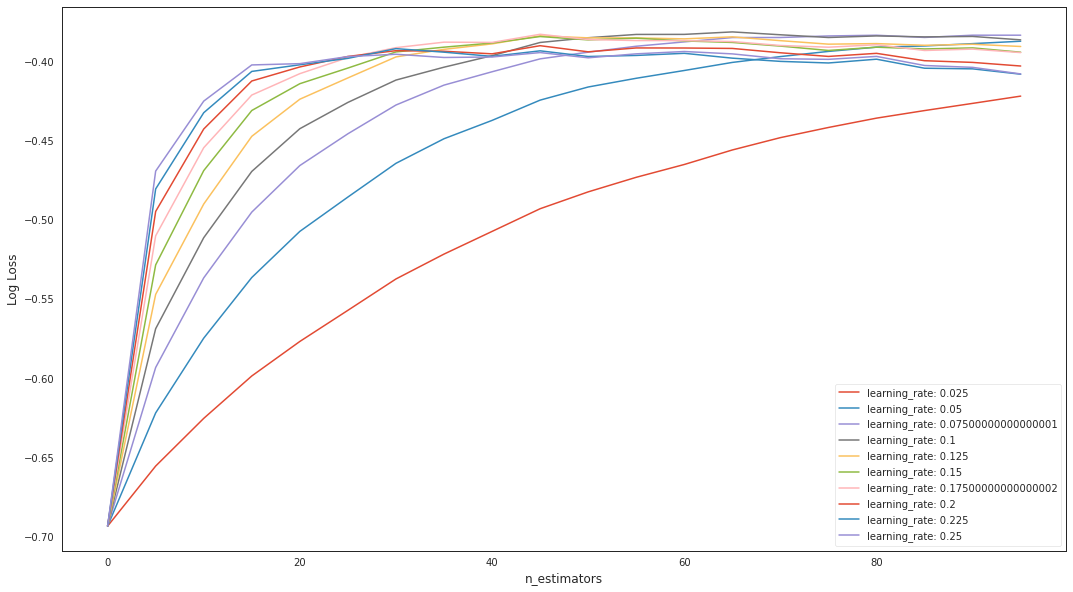

In [24]:
xgb = XGBClassifier(max_depth = 3,
                    min_child_weight = 5,
                    gamma = 0.1,
                    colsample_bytree = 0.6,
                    subsample = 0.7,
                    reg_alpha = 0.95,
                    reg_lambda = 1)

n_estimators = np.arange(0, 100, 5)
learning_rate = np.arange(0.025, 0.251, 0.025)

param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators)
kfold = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 1)
grid_search = GridSearchCV(xgb, param_grid, scoring = "neg_log_loss", n_jobs = 4, cv = kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))

for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label = 'learning_rate: ' + str(value))

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

A learning rate around 0.15 and a number of estimators around 55 seems the best approach.

In [25]:
xgb = XGBClassifier(random_state = 1)

params = {'n_estimators' : np.arange(10, 60, 1),
          'learning_rate' : np.arange(0.10, 0.25, 0.025),
          'max_depth': [3],
          'min_child_weight': [5],
          'gamma' : [0.1],
          'colsample_bytree': [0.6],
          'subsample': [0.7],
          'reg_alpha':[0.1],
          'reg_lambda':[0.075]
         }

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)

Fitting 8 folds for each of 300 candidates, totalling 2400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:   11.6s



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.125, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=55, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0.1, reg_lambda=0.075, scale_pos_weight=1,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best normalized gini score for 5-fold search:
0.8317762201034258

 Best hyperparameters:
{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.125, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 55, 'reg_alpha': 0.1, 'reg_lambda': 0.075, 'subsample': 0.7}


[Parallel(n_jobs=4)]: Done 2400 out of 2400 | elapsed:   19.8s finished


The final Gini score is 0.831. Now we can compare the final tuned model with the original XGBoost model with default parameters.

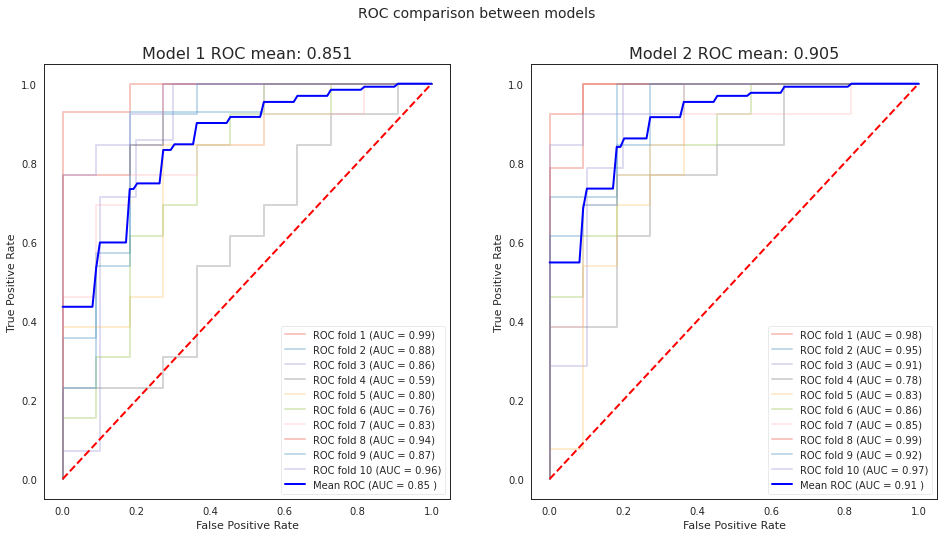

In [26]:
y_train = y_train.reset_index().iloc[:,1]
xx_train = X_train.values

xgb1 = XGBClassifier(random_state = 1)

xgb2 = XGBClassifier(learning_rate = 0.125,
                     n_estimators = 55, 
                     max_depth = 3,
                     min_child_weight = 5,
                     gamma = 0.1,
                     colsample_bytree = 0.6,
                     subsample = 0.7,
                     reg_alpha = 0.1,
                     reg_lambda = 0.075, 
                     random_state = 1)

def compare_ROC(model1, model2, x, y, folds = 8):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
    fig.suptitle('ROC comparison between models', size = 14)
    
    # CV strategy
    cv = StratifiedKFold(n_splits = 10, shuffle = False)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for xtrain, xtest in cv.split(x, y_train):
        prediction = model1.fit(x[xtrain], y[xtrain]).predict_proba(x[xtest])
        fpr, tpr, t = roc_curve(y[xtest], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax1.plot(fpr, tpr, lw = 2, alpha = 0.3, label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i = i+1

    ax1.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'red')
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax1.plot(mean_fpr, mean_tpr, color = 'blue',
             label = r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw = 2, alpha = 1)

    ax1.set_xlabel('False Positive Rate', size = 11)
    ax1.set_ylabel('True Positive Rate', size = 11)
    tit1 = 'Model 1 ROC mean: {}'.format(round(mean_auc, 3))
    ax1.set_title(tit1, size = 16)
    ax1.legend(loc = "lower right")
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 1
    
    for xtrain, xtest in cv.split(x, y_train):
        prediction = model2.fit(x[xtrain], y[xtrain]).predict_proba(x[xtest])
        fpr, tpr, t = roc_curve(y[xtest], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax2.plot(fpr, tpr, lw = 2, alpha = 0.3, label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i = i+1

    ax2.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'red')
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax2.plot(mean_fpr, mean_tpr, color = 'blue',
             label = r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw = 2, alpha = 1)

    ax2.set_xlabel('False Positive Rate', size = 11)
    ax2.set_ylabel('True Positive Rate', size = 11)
    tit2 = 'Model 2 ROC mean: {}'.format(round(mean_auc, 3))
    ax2.set_title(tit2, size = 16)
    ax2.legend(loc = "lower right")

compare_ROC(xgb1, xgb2, xx_train, y_train)

We managed to increase the accuracy of the XGBoost significantly from 0.85 up to 0.91, being AUC = 0.83 the worst iteration. It also seems clear that the tuned model is more stable than the default one.

Now we will repeat this procedure with the rest of the models.

In [27]:
# Initial Gini 0.73. Tuned model Gini = 
rf = ensemble.RandomForestClassifier(random_state = 1)

params = {"n_estimators": [15], 
          "max_depth": [4],
          'bootstrap': [True],
          'max_features': ['auto'],
          'min_samples_leaf': [7],
          'min_samples_split': [2]
          }

grid_search = GridSearchCV(
    estimator = rf,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



 Best estimator:
RandomForestClassifier(max_depth=4, min_samples_leaf=7, n_estimators=15,
                       random_state=1)

 Best normalized gini score for 5-fold search:
0.8271957821590172

 Best hyperparameters:
{'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 15}


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.2s finished


Random Forest
* Initial Gini score = 0.79
* Tuned model Gini score = 0.827 

In [28]:
# initial Gini = 0.803. Tuned model Gini = 0.83
exttrees = ensemble.ExtraTreesClassifier(random_state = 1) 

params = {"n_estimators": [45], 
          "max_depth": [3],
          'min_samples_split': [2],
          'min_samples_leaf' : [1],
          'min_weight_fraction_leaf': [0.2]
          }

grid_search = GridSearchCV(
    estimator = exttrees,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits

 Best estimator:
ExtraTreesClassifier(max_depth=3, min_weight_fraction_leaf=0.2, n_estimators=45,
                     random_state=1)

 Best normalized gini score for 5-fold search:
0.8219108556884291

 Best hyperparameters:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 45}


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.3s finished


Extra Trees Classifier:
* Initial Gini score = 0.803
* Tuned model Gini score = 0.83

In [29]:
# initial Gini = 0.819
lr = linear_model.LogisticRegression(random_state = 1) 

params = {"penalty": ['l1', 'l2', 'elasticnet', None], 
          "C": np.arange(-3, 3, 0.1)
          }

grid_search = GridSearchCV(
    estimator = lr,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 240 candidates, totalling 1920 fits


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.7s



 Best estimator:
LogisticRegression(C=0.5000000000000031, random_state=1)

 Best normalized gini score for 5-fold search:
0.828751212023271

 Best hyperparameters:
{'C': 0.5000000000000031, 'penalty': 'l2'}


[Parallel(n_jobs=4)]: Done 1920 out of 1920 | elapsed:    4.2s finished


Logistic Regression:
* Initial Gini score = 0.818
* Tuned model Gini score = 0.839  

In [30]:
# From Gini = 0.82 to Gini = 0.846
lr = linear_model.RidgeClassifier(random_state = 1) 

params = {'alpha': np.arange(300, 400, 1)}

grid_search = GridSearchCV(
    estimator = lr,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    1.5s



 Best estimator:
RidgeClassifier(alpha=300, random_state=1)

 Best normalized gini score for 5-fold search:
0.7938853425985779

 Best hyperparameters:
{'alpha': 300}


[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    3.8s finished


Ridge:
* Initial Gini score = 0.82
* Tuned model Gini score = 0.846  

In [31]:
# Initial Gini 0.77 to 0.85
lgbm = lightgbm.LGBMClassifier(random_state = 1) 

params = {
    'learning_rate': [0.1],
    'n_estimators': [110],
    'max_depth': [2],
    'num_leaves': [3],
    'max_bin' :  [2],
    'min_child_samples': [2], 
    'min_child_weight': [0.9],
    'min_sum_hessian_in_leaf' : [0.1],
    'feature_fraction' : [0.7],
    'bagging_fraction' : [0.4],
    'bagging_freq' : [4],
    'min_split_gain': [0],
    'colsample_bytree': [0.5],
    'subsample': [0.5],
    'subsample_freq': [1],
    'reg_alpha': [0],
    'reg_lambda': [0.4]
    }

grid_search = GridSearchCV(
    estimator = lgbm,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits

 Best estimator:
LGBMClassifier(bagging_fraction=0.4, bagging_freq=4, colsample_bytree=0.5,
               feature_fraction=0.7, max_bin=2, max_depth=2,
               min_child_samples=2, min_child_weight=0.9, min_split_gain=0,
               min_sum_hessian_in_leaf=0.1, n_estimators=110, num_leaves=3,
               random_state=1, reg_alpha=0, reg_lambda=0.4, subsample=0.5,
               subsample_freq=1)

 Best normalized gini score for 5-fold search:
0.8343315691661279

 Best hyperparameters:
{'bagging_fraction': 0.4, 'bagging_freq': 4, 'colsample_bytree': 0.5, 'feature_fraction': 0.7, 'learning_rate': 0.1, 'max_bin': 2, 'max_depth': 2, 'min_child_samples': 2, 'min_child_weight': 0.9, 'min_split_gain': 0, 'min_sum_hessian_in_leaf': 0.1, 'n_estimators': 110, 'num_leaves': 3, 'reg_alpha': 0, 'reg_lambda': 0.4, 'subsample': 0.5, 'subsample_freq': 1}


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.2s finished


LightGBM:
* Initial Gini score = 0.77
* Tuned model Gini score = 0.85  

In [32]:
# Initial Gini 0.79 to 0.83
lr = neighbors.KNeighborsClassifier() 

params = {
    'n_neighbors': [9],
    'weights': ['distance'],
    'algorithm': ['auto'],
    'leaf_size': [1],
    'p' : [2]
    }

grid_search = GridSearchCV(
    estimator = lr,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

Fitting 8 folds for each of 1 candidates, totalling 8 fits

 Best estimator:
KNeighborsClassifier(leaf_size=1, n_neighbors=9, weights='distance')

 Best normalized gini score for 5-fold search:
0.7958144796380089

 Best hyperparameters:
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.1s finished


KNN:
* Initial Gini score = 0.79
* Tuned model Gini score = 0.83  

In [33]:
# initial Gini = 0.821 to 0.845
from sklearn import svm
svm = svm.SVC(random_state = 1)

params = {
    'kernel': ['linear'],
    'C': [0.2],
    'degree': [0],
    'gamma': ['scale'],
    }

grid_search = GridSearchCV(
    estimator = svm,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits

 Best estimator:
SVC(C=0.2, degree=0, kernel='linear', random_state=1)

 Best normalized gini score for 5-fold search:
0.8180197559793148

 Best hyperparameters:
{'C': 0.2, 'degree': 0, 'gamma': 'scale', 'kernel': 'linear'}


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.1s finished


SVM:
* Initial Gini score = 0.821
* Tuned model Gini score = 0.845  

In [34]:
# initial Gini = 0.815 to 0.847
nusvm = svm.NuSVC(random_state = 1)

params = {
    'kernel': ['linear'],
    'nu': [0.8],
    'degree': [1],
    'gamma': ['scale'],
    }

grid_search = GridSearchCV(
    estimator = nusvm,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

AttributeError: 'SVC' object has no attribute 'NuSVC'

NuSVC:
* Initial Gini score = 0.815
* Tuned model Gini score = 0.847  

In [35]:
# initial Gini = 0.807 to 0.827
lda = svm.LinearSVC()

params = {
    'penalty' : ['l1'],
    'loss': ['hinge'],
    'tol': [1.1],
    'C': [0.08],
    'multi_class': ['crammer_singer']
    }

grid_search = GridSearchCV(
    estimator = lda,
    param_grid = params,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 8,
    verbose = True
)
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search:' % (5))
print(grid_search.best_score_ * 2 - 1)  
print('\n Best hyperparameters:')
print(grid_search.best_params_)

AttributeError: 'SVC' object has no attribute 'LinearSVC'

Logistic Regression:
* Initial Gini score = 0.818
* Tuned model Gini score = 0.839  

In [36]:
def get_models():
    models = dict()
    
    models['lgbm'] = lightgbm.LGBMClassifier(objective = 'binary',
                             metrics = 'auc',
                             learning_rate = 0.1,
                             max_depth = 2,
                             max_bin = 2,
                             n_estimators = 280,
                             num_leaves = 3,
                             min_child_samples = 2, 
                             min_child_weight = 0.9,
                             min_sum_hessian_in_leaf= 0.1,
                             feature_fraction = 0.7,
                             bagging_fraction = 0.4,
                             bagging_freq = 4,
                             random_state = 1,
                             subsample = 0.5,
                             colsample_bytree = 0.5,
                             subsample_freq = 1,
                             reg_alpha = 0,                      
                             reg_lambda = 0.4)
       
    models['LR'] = linear_model.LogisticRegression(
                            random_state = 1,
                            C = 2.6, 
                            penalty = 'l2') 
    
    models['Ridge'] = linear_model.RidgeClassifier(
                            random_state = 1,
                            alpha = 350) 
    
    models['ExtT'] = ensemble.ExtraTreesClassifier(
                            random_state = 1,
                            n_estimators = 45, 
                            max_depth = 3,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            min_weight_fraction_leaf = 0.2)
    
    models['RF'] = ensemble.RandomForestClassifier(
                            random_state = 1,
                            n_estimators = 45,
                            max_depth = 4) 
    
    models['XGB'] = XGBClassifier(learning_rate = 0.15,
                            n_estimators = 25, 
                            max_depth = 3,
                            min_child_weight = 5,
                            gamma = 0.1,
                            colsample_bytree = 0.6,
                            subsample = 0.7,
                            reg_alpha = 0.1,
                            reg_lambda = 0.075, 
                            random_state = 1)
    
    models['SVC'] = svm.SVC(random_state = 1, 
                           kernel = 'linear',
                           C = 0.2,
                           degree = 0,
                           gamma = 'scale')

    models['NuSVC'] = svm.NuSVC(random_state = 1,
                               kernel = 'linear',
                               nu = 0.8,
                               degree = 1,
                               gamma = 'scale')
    
    models['LinearSVC'] = svm.LinearSVC(
                               penalty = 'l1',
                               loss = 'hinge',
                               tol = 1.1,
                               C = 0.08,
                               multi_class = 'crammer_singer')
    
    models['LDA'] = discriminant_analysis.LinearDiscriminantAnalysis(
                            solver = 'svd',
                            n_components = 1,
                            tol = 0.9,
                            store_covariance = True)

    return models
 
models = get_models()
# evaluate the models and store results
results, names = list(), list()


# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(model, X_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = 4, error_score='raise')
    return scores

for name,model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

AttributeError: 'SVC' object has no attribute 'SVC'

Not all models performance is good enough. We will create now an ensemble model just with Ridge, ExtraTrees, NuSVC, LinearSVC, LDA and XGBoost.

In [37]:
def get_voting():
    models = list()
    models.append(('Ridge', ridge))
    models.append(('ExtT', ExtT))
    models.append(('NuSVC', NuSVC))
    models.append(('LinearSVC', LinearSVC))
    models.append(('xgb', XGB))
    ensemble = VotingClassifier(estimators = models, voting = 'hard')
    return ensemble

def get_models():
    models = dict()
    models['Ridge'] = linear_model.RidgeClassifier(
                            random_state = 1,
                            alpha = 350) 
    
    models['ExtT'] = ensemble.ExtraTreesClassifier(
                            random_state = 1,
                            n_estimators = 45, 
                            max_depth = 3,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            min_weight_fraction_leaf = 0.2)

    models['NuSVC'] = svm.NuSVC(random_state = 1,
                               kernel = 'linear',
                               nu = 0.8,
                               degree = 1,
                               gamma = 'scale')
    
    models['LinearSVC'] = svm.LinearSVC(
                               penalty = 'l1',
                               loss = 'hinge',
                               tol = 1.1,
                               C = 0.08,
                               multi_class = 'crammer_singer')
    
    models['LDA'] = discriminant_analysis.LinearDiscriminantAnalysis(
                            solver = 'svd',
                            n_components = 1,
                            tol = 0.9,
                            store_covariance = True)
    
    models['XGB'] = XGBClassifier(learning_rate = 0.15,
                            n_estimators = 25, 
                            max_depth = 3,
                            min_child_weight = 5,
                            gamma = 0.1,
                            colsample_bytree = 0.6,
                            subsample = 0.7,
                            reg_alpha = 0.1,
                            reg_lambda = 0.075, 
                            random_state = 1)

    return models

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels = names, showmeans = True)
pyplot.show()

AttributeError: 'SVC' object has no attribute 'NuSVC'

These models showed the best performance. They all are tuned and cross validated.

In [38]:
from sklearn.ensemble import VotingClassifier

ridge = linear_model.RidgeClassifier(
                random_state = 1,
                alpha = 350) 
    
ExtT = ensemble.ExtraTreesClassifier(
                random_state = 1,
                n_estimators = 45, 
                max_depth = 3,
                min_samples_split = 2,
                min_samples_leaf = 1,
                min_weight_fraction_leaf = 0.2)

NuSVC = svm.NuSVC(random_state = 1,
               kernel = 'linear',
               nu = 0.8,
               degree = 1,
               gamma = 'scale')

LinearSVC = svm.LinearSVC(
               penalty = 'l1',
               loss = 'hinge',
               tol = 1.1,
               C = 0.08,
               multi_class = 'crammer_singer')

XGB = XGBClassifier(learning_rate = 0.15,
                            n_estimators = 25, 
                            max_depth = 3,
                            min_child_weight = 5,
                            gamma = 0.1,
                            colsample_bytree = 0.6,
                            subsample = 0.7,
                            reg_alpha = 0.1,
                            reg_lambda = 0.075, 
                            random_state = 1)

final_model = list()

final_model.append(('ExtTreeS', ExtT))    
final_model.append(('Ridge', ridge))
final_model.append(('NuSVM', NuSVC))
final_model.append(('LinearSVC', LinearSVC))
final_model.append(('XGB', XGB))


ensemble = VotingClassifier(estimators = final_model, voting = 'hard')
ensemble.fit(X_train, y_train)
ensemble

AttributeError: 'SVC' object has no attribute 'NuSVC'